## Import modules

In [1]:
#import standard modules
%run ../load_main.py
from WRFChemToolkit.analysis import aerosols_202 as aer, plots as pt, statistics as st, IGP as igp

#for getting only IGP data
import salem
shp_igp= salem.read_shapefile("/exports/csce/datastore/geos/users/s1878599/phd_work/IGP/gadm_data/IGP/IGP.shp")

WRFchem outputs data path is: dpath=/geos/d21/s1878599/IGP


## Create functions for calculating emissions 

In [2]:
#uniform emission rates between gas and aerosols.
def emi_unirates_anthro(ds): 
   
    "Convert gas emissions rates from [mol km-2 hr-1] to [ug m-2 s-1] as aerosols are."
    
    # speciated gas species for anthro emissions in WRF-Chem MOZART-MOSAIC 202 and their moalr weight.
    molw ={ "CO":28, "NO":30,"NO2":46,"SO2":64,"BIGALK":72,"BIGENE":56, "C2H4":28, "C2H5OH":46, "C2H6":30, "C3H8":44, "C3H6":42, 
            "CH2O":30, "CH3CHO":44, "CH3COCH3":58, "CH3OH":32, "MEK":72, "TOLUENE":92, "BENZENE":78,"XYLENE":106, "HONO":47,
            "NH3":17, "C10H16":136, "GLY":58, "MGLY":72, "ISOP":68, "MACR":70, 
            "MVK":70, "HCOOH":46, "C2H2":26}
    
    gug=1e+6 #g to ug.
    km2m2=1e+6 # km2 to m2.
    hrsec=3600 #hour to sec 
    conv = gug/(km2m2*hrsec) 
    dsc=ds.copy(deep=True)
    for sp in molw.keys():
        dsc["E_"+ sp]= dsc["E_"+ sp]*molw[sp]*conv  
        dsc["E_"+ sp].attrs["units"]="ug m-2 s-1"

    return dsc


# Calcualte hourly total emissions at each gridcell.
def calc_emiantro(ds,sres):
    """
    Calculate hourly total emissions at each gridcell ["Gg hour-1"] depending on the spatial resolution of gridcell (sres).
    """
    km2m2=1e+6 # km2 to m2. sres in km need to convert in m.
    hrsec=3600 #hour to sec
    ugGg=1e-15 #ug to Gg
    
    # create empty datarray to be filled with total emissions.
    ds["tot_emi"]= xr.DataArray(np.zeros(ds["E_CO"].shape), coords=ds.coords, dims=ds.dims)
   
    for da in ds.data_vars.values():
        if da.name.startswith("E_"):
            ds[da.name]=ds[da.name]*hrsec*(sres*sres)*km2m2*ugGg   #  emissions at each gridpoint at each hour.
            ds[da.name].attrs["units"]="Gg hour-1"
            
            ds["tot_emi"]=ds["tot_emi"]+ds[da.name]  #adding to total emissions.
            
    ds["tot_emi"].attrs["units"]="Gg hour-1"


## Calculate emissions difference

### Prepare emission difference

In [3]:
#Get anthropogenic emissions data for each season, both for base (b) and perturbed case (p).
#Files are hourly emissions for 24h.

aab_pth = dpath+'/inp_emiss/autumn/emi_base/wrfchemi*'
aap_pth = dpath+'/inp_emiss/autumn/emi_ptrb/wrfchemi*'
awb_pth = dpath+'/inp_emiss/winter/emi_base/wrfchemi*'
awp_pth = dpath+'/inp_emiss/winter/emi_ptrb/wrfchemi*'
apmb_pth = dpath+'/inp_emiss/premonsoon/emi_base/wrfchemi*'
apmp_pth = dpath+'/inp_emiss/premonsoon/emi_ptrb/wrfchemi*'
amb_pth = dpath+'/inp_emiss/monsoon/emi_base/wrfchemi*'
amp_pth = dpath+'/inp_emiss/monsoon/emi_ptrb/wrfchemi*'

aab = xr.open_mfdataset(aab_pth, concat_dim='Time')
aap = xr.open_mfdataset(aap_pth,concat_dim='Time')
awb = xr.open_mfdataset(awb_pth, concat_dim='Time')
awp = xr.open_mfdataset(awp_pth,concat_dim='Time')
apmb = xr.open_mfdataset(apmb_pth, concat_dim='Time')
apmp = xr.open_mfdataset(apmp_pth,concat_dim='Time')
amb = xr.open_mfdataset(amb_pth , concat_dim='Time')
amp = xr.open_mfdataset(amp_pth ,concat_dim='Time') 

# put base and perturbed emissions in a dict by season.
emi_a={"aut":[aab,aap], "win":[awb,awp],"pmon":[apmb,apmp],"mon":[amb,amp]}

In [4]:
#Calculate hourly total emissions at each gridpoint [Gg hour-1].
for v in emi_a.values():
    for ds in v:
        temp=emi_unirates_anthro(ds)
        calc_emiantro(temp,sres=20)
        ds["tot_emi"]=temp.tot_emi

### Calculate total emissions difference for the perturbed period in the whole IGP

In [5]:
emitot_igp={'pmon': {}, 'mon': {}, 'aut': {}, 'win': {}}
for s in emi_a.keys():
        v0igp=emi_a[s][0].salem.roi(shape=shp_igp)
        v1igp=emi_a[s][1].salem.roi(shape=shp_igp)
        tb= (v0igp['tot_emi'].sum(dim=['Time', 'emissions_zdim_stag',"south_north","west_east"])*7).values  # 7 days. Each file has 24h emi data.
        tp= (v1igp['tot_emi'].sum(dim=['Time', 'emissions_zdim_stag',"south_north","west_east"])*7).values
        d=tp-tb # difference Gg
        emitot_igp.update({s:d})

In [6]:
emitot_igp

{'pmon': 3604.379176526505,
 'mon': 3587.8852291334624,
 'aut': 3612.8284399086115,
 'win': 3741.914108524579}

### Calculate weighted total emissions difference for the perturbed period in the whole IGP

In [7]:
# Calculate weights (number of gridcells with emissions 2.8Mg during the simulation period).
weight_igp={'pmon': {}, 'mon': {}, 'aut': {}, 'win': {}}
for s in emi_a.keys():
        base= emi_a[s][0].salem.roi(shape=shp_igp)['tot_emi'].sum(dim=['Time', 'emissions_zdim_stag'])
        per= emi_a[s][1].salem.roi(shape=shp_igp)['tot_emi'].sum(dim=['Time', 'emissions_zdim_stag'])
        d=per-base
        w = np.count_nonzero(d.values>2.8e-3) # 2.8 Mg correspod to a rate of 0.001 g m-2 day-1.
        weight_igp.update({s:w})
        
#Weighted emissions
w_emitot_igp={'pmon': {}, 'mon': {}, 'aut': {}, 'win': {}}
for s in emitot_igp.keys():
    we=emitot_igp[s]/weight_igp[s]
    w_emitot_igp.update({s:we})

In [8]:
weight_igp

{'pmon': 2288, 'mon': 2288, 'aut': 2288, 'win': 2288}

In [9]:
w_emitot_igp

{'pmon': 1.5753405491811647,
 'mon': 1.5681316560898,
 'aut': 1.5790334090509666,
 'win': 1.6354519705089945}

## Prepare aerosols outputs

In [10]:
#Get aerosol outputs data for each season, both for base (b) and perturbed case (p).
oab_pth=dpath+'/outputs/autumn/wrfout_d01_2017-11-01_00:00:00_.nc'
oap_pth=dpath+'/outputs/autumn/anthro_prtb/wrfout_d01_2017-11-01_00:00:00_ap.nc'
owb_pth=dpath+'/outputs/winter/wrfout_d01_2018-01-22_00:00:00_.nc'
owp_pth=dpath+'/outputs/winter/anthro_prtb/wrfout_d01_2018-01-22_00:00:00_ap.nc'
opmb_pth=dpath+'/outputs/premonsoon/wrfout_d01_2017-05-02_00:00:00.nc'
opmp_pth=dpath+'/outputs/premonsoon/anthro_prtb/wrfout_d01_2017-05-02_00:00:00_ap.nc'
omb_pth=dpath+'/outputs/monsoon/wrfout_d01_2017-07-17_00:00:00_.nc'
omp_pth=dpath+'/outputs/monsoon/anthro_prtb/wrfout_d01_2017-07-17_00:00:00_ap.nc'

oab= xr.open_mfdataset(oab_pth).sel(Time=slice(1,56))
oap=xr.open_mfdataset(oap_pth).sel(Time=slice(1,56)) 
owb= xr.open_mfdataset(owb_pth).sel(Time=slice(1,56))
owp=xr.open_mfdataset(owp_pth).sel(Time=slice(1,56))
opmb= xr.open_mfdataset(opmb_pth).sel(Time=slice(1,56))
opmp=xr.open_mfdataset(opmp_pth).sel(Time=slice(1,56))  
omb=xr.open_mfdataset(omb_pth).sel(Time=slice(1,56))
omp=xr.open_mfdataset(omp_pth).sel(Time=slice(1,56))

# put everything in a dict by season
saout={"aut":[oab,oap], "win":[owb,owp],"pmon":[opmb,opmp],"mon":[omb,omp]}

In [11]:
#get aerosols data.
aaer={}
for k,v in saout.items():
    
    baer= aer.get_aerosols(v[0])
    baer.attrs=v[0].attrs
    paer= aer.get_aerosols(v[1])
    paer.attrs=v[1].attrs
    
    aaer.update({k : [baer,paer]})

## Calculate sensitivities

In [12]:
#Create function for surface sensitivity at gridpoint ij for a specified species.

def get_s_ij(bds,pds,delta_emi,var,thres):
    """
    bds = base output.
    pds = perturbed output.
    delta_emi = total difference in emissions [Gg].
    var = variable for which calculate sensitivity.
    thres= threshold in aerosols difference for calculating senstivity  [ug m-3].
    """
    # surface total difference in concentration over sim period [ug/m3].
    diff_var = (pds[var].sum(dim ='Time')-bds[var].sum(dim ='Time'))[0, :, :]
    
    # Apply threshold and put nan to zero.
    diff_masked = diff_var.where(diff_var.values>thres) 
    diff_masked.values=np.nan_to_num(diff_masked.values, copy=False,nan=0.0, posinf=0.0, neginf=0.0)

    # compute sensitivity.
    s = diff_masked/delta_emi
    return xr.Dataset({'sty':s},coords=dict(bds.coords))
    

# calculate sensitivities for all season and put in a dict.
def sensitivity(do,de,var,thres):
    "do= output dict,de=emissions dict,var=varname thres=sesnitivity calcualtion treshold "
    
    shdfigp= salem.read_shapefile("/exports/csce/datastore/geos/users/s1878599/phd_work/IGP/gadm_data/IGP/IGP.shp")
    s={}
    for k in do.keys():
        
        sens= get_s_ij(do[k][0],do[k][1],de[k],var,thres) # calc sensitivity.
        sens.attrs=do[k][0].attrs 
        
        sens_igp = sens.salem.roi(shape=shdfigp)  # get sensitivity only for IGP area.
        s.update({k:sens_igp})

    return s

In [13]:
# calculate sensitivities for PM2.5
spm25=sensitivity(aaer,w_emitot_igp,"pm25_tot",thres=4)

In [14]:
# calculate sensitivities for POA
sPOA=sensitivity(aaer,w_emitot_igp,"pm10_POA",thres=1)

In [15]:
# calculate sensitivities for SOA
sSOA=sensitivity(aaer,w_emitot_igp,"pm10_SOA",thres=1)

In [16]:
# calculate sensitivities for OA
sOA=sensitivity(aaer,w_emitot_igp,"pm10_OA",thres=1)

## PLOTS

In [17]:
#SPATIAL PLOT FUNCTION

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.colorbar import colorbar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader

def set_formatter(axes,leftlab):
    for ax in axes:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.3, color='k', alpha=0.4, linestyle='-')
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.xlocator = mticker.FixedLocator([70,80,90])
        gl.xlabel_style = {'size': 11,'color': 'grey'}
        gl.ylabels_right = False
        gl.ylabels_left = False
        
        if leftlab==True:
            gl.ylabels_left = True
            gl.ylocator = mticker.FixedLocator([20,25,30,35])
            gl.ylabel_style = {'size': 11,'color': 'grey'}
        
        #ax.add_feature(cfeature.COASTLINE, lw=0.5)
        #ax.add_feature(cfeature.BORDERS, lw=0.5)
        
    # get lon values only n the last ax
        if ax==axes[3]:
            gl.xlabels_bottom = True
            gl.xlocator = mticker.FixedLocator([70,80,90])
            gl.xlabel_style = {'size': 11,'color': 'grey'}
    
    
def set_admin(axes, shp_path):
    for ax,shp in zip(axes,shp_path):
            admin = list(shpreader.Reader(shp).geometries())
            # Add data from Global Administrative Areas Dataset GDAM https://gadm.org/index.html
            ax.add_geometries(admin, ccrs.PlateCarree(),
                      edgecolor='black', facecolor='none', alpha=1, lw=0.3)
            


def sensplot(lat,lon,pmds,mds,ads,wds,panels=["(a)","(d)","(g)","(j)"],vmin=None,vmax=None,title=None, label=None, leftlab=False,bar=False,axs=False, cmap="OrRd",levs=10, 
            delta=50,figsize=[7, 10],format="%.2f",save=False,spath=None,name="plot",savef='pdf', dpi=100):

    fig, axes =plt.subplots(nrows=4,ncols=1,figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree()})
    
    igp_shp="/exports/csce/datastore/geos/users/s1878599/phd_work/IGP/gadm_data/IGP/IGP.shp"
    shp_path=(igp_shp,igp_shp,igp_shp,igp_shp)
    
    set_formatter(axes.flatten(),leftlab)
    set_admin(axes.flatten(), shp_path)
 
    #Getting values.
    
    vpm=pmds[:,:].values
    vm= mds[:,:].values 
    va= ads[:,:].values 
    vw= wds[:,:].values
   
    import math
    if vmax is None:  # Get the max value in the array to plot.
        vmax =np.array([np.nanmax(vpm),np.nanmax(vm),np.nanmax(va),np.nanmax(vw)]).max() 
    if vmin is None:  # Get the max value in the array to plot.
        vmin =np.array([np.nanmin(vpm),np.nanmin(vm),np.nanmin(va),np.nanmin(vw)]).min()  
    print(vmin,vmax)
    l = np.linspace(vmin, vmax, levs)  # number of levels for which divide the bar. Customise 
    # premonsoon
    cspm=axes[0].contourf(lon,lat,vpm,transform=ccrs.PlateCarree(),cmap=cmap, vmin=vmin,vmax=vmax,levels=l,
                            extend="both")
    cspm.cmap.set_over("#FF0000")
    cspm.cmap.set_under("#FFFFFF")
                                                 
    # monsoon
    csm=axes[1].contourf(lon,lat,vm,transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax,levels=l,
                              extend="both") 
    csm.cmap.set_over("#FF0000")
    csm.cmap.set_under("#FFFFFF")
    #autumn
    csa=axes[2].contourf(lon,lat,va,transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax,levels=l,
                           extend="both")
    csa.cmap.set_over("#FF0000")
    csa.cmap.set_under("#FFFFFF")
    #winter
    csw=axes[3].contourf(lon,lat,vw,transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax,levels=l,
                           extend="both")
    csw.cmap.set_over("#FF0000")
    csw.cmap.set_under("#FFFFFF")
    
    if axs==True:
        axes[0].text(-0.25, 0.55, 'PRE-MONSOON', va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor', fontsize=10,
        transform=axes[0].transAxes)
        axes[1].text(-0.25, 0.55, 'MONSOON', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=10,
        transform=axes[1].transAxes)
        axes[2].text(-0.25, 0.55, 'POST-MONSOON', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=10,
        transform=axes[2].transAxes)
        axes[3].text(-0.25, 0.55, 'WINTER', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=10,
        transform=axes[3].transAxes)
    
     #add panel boxes
    panels=panels
    for ax,p in zip(fig.axes,panels):
        ax.annotate(p, xy=(1, 1), xytext=(-5, -5), fontsize=12,
        xycoords='axes fraction', textcoords='offset points',
        bbox=dict(facecolor='white',edgecolor='white', alpha=0.8),
        horizontalalignment='right', verticalalignment='top')
    
    
    if bar==True:
        delta
    #fig.subplots_adjust(right=0.8,hspace=0.4)  
        cbar_ax = fig.add_axes([0.92, 0.1, 0.05, 0.8])  #[left, bottom, width, height]
        cbar= fig.colorbar(csw, cax=cbar_ax,pad=0.35,shrink=1, format=format)
        cbar.set_label(label,fontsize=12)
        cbar.ax.tick_params(labelsize='medium')
        cbar.set_ticks(list(range(0, vmax+delta, delta)))

    if title is not None:
        axes[0].set_title(title, fontsize=12,pad=20)
    
    
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.0)
    
    #save
    if save:
        plt.savefig( spath + name +'.' + savef, format=savef, dpi=dpi, bbox_inches = "tight")
    
    fig.show()

In [18]:
# define lat lon
lon =spm25["aut"].XLONG[0,:, :]
lat =spm25["aut"].XLAT[0,:, :]

0.0 3000


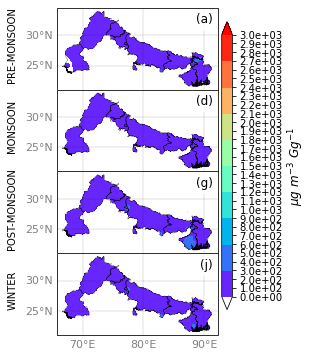

In [20]:
#PM2.5
savepth="./"
sensplot(lat,lon,spm25["pmon"].sty,spm25["mon"].sty,spm25["aut"].sty,spm25["win"].sty,cmap="rainbow",axs=True,bar=True,leftlab=True,vmax=3000,label="$\mu g~m^{-3}~Gg^{-1}$",
        levs=11,delta=100,format="%.1e",figsize=[3,5],save=True, spath=savepth,name="anthro_pm25",savef='png', dpi=300)

0.0 500


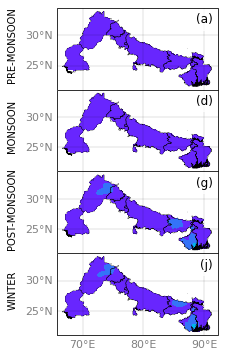

In [21]:
#POA
sensplot(lat,lon,sPOA["pmon"].sty,sPOA["mon"].sty,sPOA["aut"].sty,sPOA["win"].sty,cmap="rainbow",axs=True,bar=False,leftlab=True,vmax=500,
        levs=11,label="$\mu g~m^{-3}~Gg^{-1}$",format="%1.e",figsize=[3,5],save=True, spath=savepth,name="anthro_poa",savef='png', dpi=300)

0.0 500


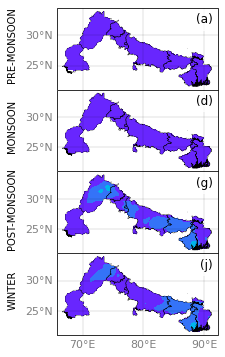

In [22]:
#OA
sensplot(lat,lon,sOA["pmon"].sty,sOA["mon"].sty,sOA["aut"].sty,sOA["win"].sty,cmap="rainbow",vmax=500,axs=True,bar=False,leftlab=True,
        levs=11,delta=30,label="$\mu g~m^{-3}~Gg^{-1}$",format="%.1e",figsize=[3,5],save=True, spath=savepth,name="anthro_oa",savef='png', dpi=300)

0.0 300


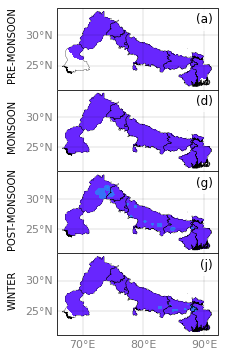

In [23]:
#SOA
sensplot(lat,lon,sSOA["pmon"].sty,sSOA["mon"].sty,sSOA["aut"].sty,sSOA["win"].sty,cmap="rainbow",vmax=300,axs=True,bar=False,leftlab=True,label="$\mu g~m^{-3}~Gg^{-1}$",
        levs=11,format="%.1e",figsize=[3,5],save=True, spath=savepth,name="anthro_soa",savef='png', dpi=300)